# EDA

## Config

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../code')
 
from constants import ACH_codes
from utils import null_detection, plot_numeric_columns, plot_categorical
from aws import s3_bucket

In [3]:
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)

In [4]:
# Read credentials
import configparser

credentials_file="..\config\credentials.ini"
config = configparser.ConfigParser()
config.read(credentials_file)

aws_access_key_id = config.get('AWS', 'aws_access_key_id')
aws_secret_access_key = config.get('AWS', 'aws_secret_access_key')

### S3 Connection

In [5]:
# S3 connection
bucket = s3_bucket(
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
    bucket_name='moneylion-project'
)

### S3 Upload Data

In [6]:
# Upload objects
files_to_upload = [
    (r'..\data\raw\loan.csv', 'loan.csv'),
    (r'..\data\raw\clarity_underwriting_variables.csv', 'clarity_underwriting_variables.csv'),
    (r'..\data\raw\payment.csv', 'payment.csv'),
    ]

In [7]:
bucket.upload_objects(files_to_upload)

File 'loan.csv' already exists.
File 'clarity_underwriting_variables.csv' already exists.
File 'payment.csv' already exists.


In [8]:
bucket.show_objects()

['clarity_underwriting_variables.csv',
 'loan.csv',
 'output/full_data_df.csv',
 'payment.csv']

## Data Model

Loan DF must be name Applications because contains originated and not originated loans.

- Prior: clarity_underwriting_variables
- Pivot: loans
- Post: payment

## 1 Loans DF - Pivot

- Loans.csv is actually an Applications table as it has openned and rejected loans
- Create Loans DF ( Only funded loans with performance can be used in the model )
- Actual Funded Loans are 6.7% from all applications (38k out from 577k)

### Load Data

#### Read Files

In [9]:
#Read Loan Data
#df_application = pd.read_csv(r'..\data\raw\loan.csv')
df_application = bucket.read_csv(file='loan.csv')

#Date format
df_application['originatedDate'] = pd.to_datetime(df_application['originatedDate'].str[:10], format='%Y-%m-%d')
df_application['applicationDate'] = pd.to_datetime(df_application['applicationDate'].str[:10], format='%Y-%m-%d')
df_application.head(5)

loanId                          anon_ssn payFrequency    apr  \
0  LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3  LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4  LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   

  applicationDate  originated originatedDate  nPaidOff  approved  isFunded  \
0      2016-02-23       False            NaT       0.0     False         0   
1      2016-01-19        True     2016-01-20       0.0      True         1   
2      2016-08-01       False            NaT       0.0     False         0   
3      2015-08-06       False            NaT       0.0     False         0   
4      2016-06-05       False            NaT       0.0     False         0   

              loanStatus  loanAmount  originallyScheduledPaymentAmount state  \
0  Withdrawn Application       500.0                            978.27    IL   
1          Paid Off Loan      3000.0                           6395.19    CA   
2  Withdrawn Application       400.0                           1199.45    MO   
3  Withdrawn Application       500.0                           1074.05    IL   
4               Rejected       350.0                            814.37    NV   

      leadType  leadCost fpStatus            clarityFraudId  hasCF  
0  bvMandatory         6      NaN  5669ef78e4b0c9d3936440e6      1  
1    prescreen         0  Checked  569eb3a3e4b096699f685d64      1  
2  bvMandatory         3      NaN  579eab11e4b0d0502870ef2f      1  
3  bvMandatory         3      NaN  555b1e95e4b0f6f11b267c18      1  
4  bvMandatory         3      NaN  5754a91be4b0c6a2bf424772      1

In [10]:
df_loans = df_application[df_application["isFunded"] == True].copy()

print("Funded Rate :", df_application["isFunded"].mean().round(5)*100)
print(df_loans.shape)

Funded Rate : 6.748
(38982, 19)


### Null Values
- nPaidOff replace null values to real 0

In [11]:
df_loans.select_dtypes(include=['object'])

loanId                          anon_ssn payFrequency  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B   
...               ...                               ...          ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8            B   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W   

           loanStatus state      leadType fpStatus            clarityFraudId  
1       Paid Off Loan    CA     prescreen  Checked  569eb3a3e4b096699f685d64  
15           New Loan    MO       organic  Checked                       NaN  
33           New Loan    NJ          lead  Checked  58b6eef8e4b0b6fca82fd426  
47      Paid Off Loan    MO       organic  Checked  58450a15e4b0bb9d6d7344c7  
54      Paid Off Loan    CA   bvMandatory  Checked  578f9346e4b0810ad5e7b72e  
...               ...   ...           ...      ...                       ...  
577564  Paid Off Loan    CA  rc_returning  Checked                       NaN  
577590  Paid Off Loan    AL          lead  Checked  587a7f49e4b08f2485d48358  
577617  Paid Off Loan    WI          lead  Checked  5769e592e4b0ab6c50364d45  
577653       New Loan    IN          lead  Checked  58668211e4b08f246e282356  
577662  Paid Off Loan    CT          lead  Checked  5840ad86e4b0bb9d6980127f  

[38982 rows x 8 columns]

In [12]:
null_detection(df_loans)

Null count per column:
clarityFraudId    6622
nPaidOff            21
fpStatus             9
dtype: int64

Percentage of nulls per column:
clarityFraudId    16.99
nPaidOff           0.05
fpStatus           0.02
dtype: float64


In [13]:
# nPaidOff Null means a real 0
df_loans["nPaidOff"] = df_loans["nPaidOff"].fillna(0)

In [14]:
null_detection(df_loans)

Null count per column:
clarityFraudId    6622
fpStatus             9
dtype: int64

Percentage of nulls per column:
clarityFraudId    16.99
fpStatus           0.02
dtype: float64


### Variables Distribution

In [15]:
df_loans.describe()

apr                applicationDate  \
count  38982.000000                          38982   
mean     527.410074  2016-07-17 16:38:22.847468032   
min        0.000000            2014-12-03 00:00:00   
25%      449.990000            2016-01-26 00:00:00   
50%      590.000000            2016-10-19 00:00:00   
75%      601.000000            2017-01-09 00:00:00   
max      705.590000            2017-03-18 00:00:00   
std      124.604931                            NaN   

                      originatedDate      nPaidOff  isFunded    loanAmount  \
count                          38982  38982.000000   38982.0  38982.000000   
mean   2016-07-18 15:22:54.726797312      0.372018       1.0    639.727644   
min              2014-12-02 00:00:00      0.000000       1.0    100.000000   
25%              2016-01-27 00:00:00      0.000000       1.0    375.000000   
50%              2016-10-19 00:00:00      0.000000       1.0    500.000000   
75%              2017-01-09 00:00:00      0.000000       1.0    700.000000   
max              2017-03-27 00:00:00     21.000000       1.0   4687.000000   
std                              NaN      1.019788       0.0    478.619761   

       originallyScheduledPaymentAmount      leadCost         hasCF  
count                      38982.000000  38982.000000  38982.000000  
mean                        1753.363425     11.921169      0.830127  
min                          187.620000      0.000000      0.000000  
25%                         1035.560000      0.000000      1.000000  
50%                         1379.000000      3.000000      1.000000  
75%                         1995.877500     10.000000      1.000000  
max                        16868.150000    200.000000      1.000000  
std                         1282.300386     20.203014      0.375526

In [16]:
plot_numeric_columns(df_loans)

In [17]:
df_loans.describe(include="object")

loanId                          anon_ssn payFrequency  \
count           38982                             38982        38982   
unique          38982                             34654            5   
top     LL-I-06644937  228060b9cc8af6a937d0321122d459f3            B   
freq                1                                12        22797   

           loanStatus  state     leadType fpStatus            clarityFraudId  
count           38982  38982        38982    38973                     32360  
unique             11     41           10        6                     30792  
top     Paid Off Loan     OH  bvMandatory  Checked  57b589afe4b0104a27f024d1  
freq            11427   6563        16569    32978                         6

In [18]:
plot_categorical(df_loans, ["payFrequency","fpStatus","loanStatus","leadType"])

### First time clients and Recurring clients
- 79% (30k) of loans are from first time clients

In [19]:
# Get First Loan per client
df_first_loan = df_loans[df_loans["nPaidOff"] == 0 ].copy()

# Get Recurring Clients
df_recurring_loan = df_loans[df_loans["nPaidOff"] > 0].copy()

df_first_loan

loanId                          anon_ssn payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
98      LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8            W  590.0   
155     LL-I-15095423  30c4d360865b5b3591e81dcf681f0a74            S  590.0   
...               ...                               ...          ...    ...   
577521  LL-I-17508871  f0b666fdd1b46c58297b3828b61047ad            M  180.2   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.0   

       applicationDate  originated originatedDate  nPaidOff  approved  \
1           2016-01-19        True     2016-01-20       0.0      True   
33          2017-03-01        True     2017-03-01       0.0      True   
54          2016-08-27        True     2016-08-29       0.0      True   
98          2015-05-26        True     2015-05-26       0.0      True   
155         2017-01-13        True     2017-01-13       0.0      True   
...                ...         ...            ...       ...       ...   
577521      2017-02-21        True     2017-02-21       0.0      True   
577590      2017-01-14        True     2017-01-14       0.0      True   
577617      2016-06-22        True     2016-06-22       0.0      True   
577653      2016-12-30        True     2016-12-30       0.0      True   
577662      2016-12-16        True     2016-12-16       0.0      True   

        isFunded     loanStatus  loanAmount  originallyScheduledPaymentAmount  \
1              1  Paid Off Loan      3000.0                           6395.19   
33             1       New Loan       400.0                           1364.87   
54             1  Paid Off Loan       800.0                           2432.08   
98             1  Paid Off Loan       300.0                            896.87   
155            1       New Loan       600.0                           1802.83   
...          ...            ...         ...                               ...   
577521         1  Returned Item       500.0                            794.60   
577590         1  Paid Off Loan       375.0                           1042.40   
577617         1  Paid Off Loan       400.0                            664.12   
577653         1       New Loan       600.0                           1868.88   
577662         1  Paid Off Loan       300.0                           1034.38   

       state     leadType  leadCost  fpStatus            clarityFraudId  hasCF  
1         CA    prescreen         0   Checked  569eb3a3e4b096699f685d64      1  
33        NJ         lead        40   Checked  58b6eef8e4b0b6fca82fd426      1  
54        CA  bvMandatory        10   Checked  578f9346e4b0810ad5e7b72e      1  
98        MO  bvMandatory         6  Rejected                       NaN      0  
155       MI         lead        25   Checked  5878b8ade4b08f24825292a4      1  
...      ...          ...       ...       ...                       ...    ...  
577521    CO         lead        25  Rejected  58aca342e4b0bf804c0e82db      1  
577590    AL         lead        25   Checked  587a7f49e4b08f2485d48358      1  
577617    WI         lead        40   Checked  5769e592e4b0ab6c50364d45      1  
577653    IN         lead        25   Checked  58668211e4b08f246e282356      1  
577662    CT         lead         6   Checked  5840ad86e4b0bb9d6980127f      1  

[30834 rows x 19 columns]

- Drop customers with 2+ active loans at the same time, this can change payment capacity and readings. Not the best practice for a first Risk model

In [20]:
# Drop duplicates
duplicated_ssn = df_first_loan[df_first_loan.duplicated(subset='anon_ssn', keep=False)]['anon_ssn'].tolist()
print("Clients with 2 active loans(invalid):",len(duplicated_ssn))

df_valid_loans = df_first_loan[~df_first_loan["anon_ssn"].isin(duplicated_ssn)]

Clients with 2 active loans(invalid): 34


### Loan Origination Trend

In [21]:
df_valid_loans.groupby("originatedDate")["loanId"].count().plot()

<Axes: xlabel='originatedDate'>

In [22]:
df_valid_loans.agg({"originatedDate":["min","max"]})

originatedDate
min     2014-12-02
max     2017-03-27

### Volume Report

In [23]:
# Volume Pipeline
VolPipeline = {}
VolPipeline["Applications"] = len(df_application)
VolPipeline["Funded Loans"] = len(df_loans)
VolPipeline["First Time Clients"] = len(df_first_loan)

VolPipeline["Clients w/ Only 1 Active Loan"] = len(df_valid_loans)
VolPipeline

{'Applications': 577682,
 'Funded Loans': 38982,
 'First Time Clients': 30834,
 'Clients w/ Only 1 Active Loan': 30800}

In [24]:
df_valid_loans.columns.tolist()

['loanId',
 'anon_ssn',
 'payFrequency',
 'apr',
 'applicationDate',
 'originated',
 'originatedDate',
 'nPaidOff',
 'approved',
 'isFunded',
 'loanStatus',
 'loanAmount',
 'originallyScheduledPaymentAmount',
 'state',
 'leadType',
 'leadCost',
 'fpStatus',
 'clarityFraudId',
 'hasCF']

## 2 Payment DF - Post

### Load Data

In [25]:
#Read Payment Data
#df_payment = pd.read_csv(r'..\data\raw\payment.csv')
df_payment = bucket.read_csv(file='payment.csv')

#Date format
df_payment['paymentDate'] = pd.to_datetime(df_payment['paymentDate'].str[:10], format='%Y-%m-%d')
df_payment.head(5)

loanId  installmentIndex  isCollection paymentDate  principal  \
0  LL-I-00000021                 1         False  2014-12-19      22.33   
1  LL-I-00000021                 2         False  2015-01-02      26.44   
2  LL-I-00000021                 3         False  2015-01-16      31.30   
3  LL-I-00000021                 4         False  2015-01-30      37.07   
4  LL-I-00000021                 5         False  2015-02-13      43.89   

     fees  paymentAmount paymentStatus paymentReturnCode  
0  147.28         169.61       Checked               NaN  
1  143.17         169.61       Checked               NaN  
2  138.31         169.61       Checked               NaN  
3  132.54         169.61       Checked               NaN  
4  125.72         169.61       Checked               NaN

### Null Values
Everything ok with the null values on this df

In [26]:
null_detection(df_payment)

Null count per column:
paymentReturnCode    657831
paymentStatus        164057
dtype: int64

Percentage of nulls per column:
paymentReturnCode    95.43
paymentStatus        23.80
dtype: float64


In [27]:
# nPaidOff Null means a real 0
df_payment["paymentStatus"] = df_payment["paymentStatus"].fillna("Scheduled")

In [28]:
null_detection(df_payment)

Null count per column:
paymentReturnCode    657831
dtype: int64

Percentage of nulls per column:
paymentReturnCode    95.43
dtype: float64


### Clean
- Re-Compute paymentAmount
- Change "Complete" in paymentStatus to "Checked"

In [29]:
paymentAmount2 = df_payment["principal"]+ df_payment["fees"]
diff = df_payment["paymentAmount"] - paymentAmount2
print("Prior Errors in paymentAmount:")
diff.describe(percentiles=[.1,.2,.3,.4,.5,.7,.8,.9])

Prior Errors in paymentAmount:


count    6.893640e+05
mean     1.186949e-01
std      5.467281e+00
min     -5.000000e+02
10%     -3.552714e-15
20%      0.000000e+00
30%      0.000000e+00
40%      0.000000e+00
50%      0.000000e+00
70%      0.000000e+00
80%      0.000000e+00
90%      7.105427e-15
max      6.517700e+02
dtype: float64

In [30]:
df_payment["paymentAmount"] = paymentAmount2

In [31]:
df_payment["paymentStatus"] = df_payment["paymentStatus"].replace({"Complete":"Checked"})

### Variables Distribution

In [32]:
df_payment.describe()

installmentIndex                    paymentDate      principal  \
count     689364.000000                         689364  689364.000000   
mean          10.553222  2016-10-17 12:33:55.782547456      45.557543   
min            1.000000            2014-12-09 00:00:00    -303.370000   
25%            5.000000            2016-04-29 00:00:00      13.180000   
50%            9.000000            2016-12-27 00:00:00      27.610000   
75%           14.000000            2017-04-14 00:00:00      53.380000   
max          105.000000            2021-02-26 00:00:00    4000.000000   
std            8.049530                            NaN      81.724683   

                fees  paymentAmount  
count  689364.000000  689364.000000  
mean       67.003994     112.561537  
min       -42.560000    -337.700000  
25%        28.820000      56.790000  
50%        51.300000      86.330000  
75%        86.440000     135.040000  
max      1257.710000    4063.600000  
std        59.789510     105.473011

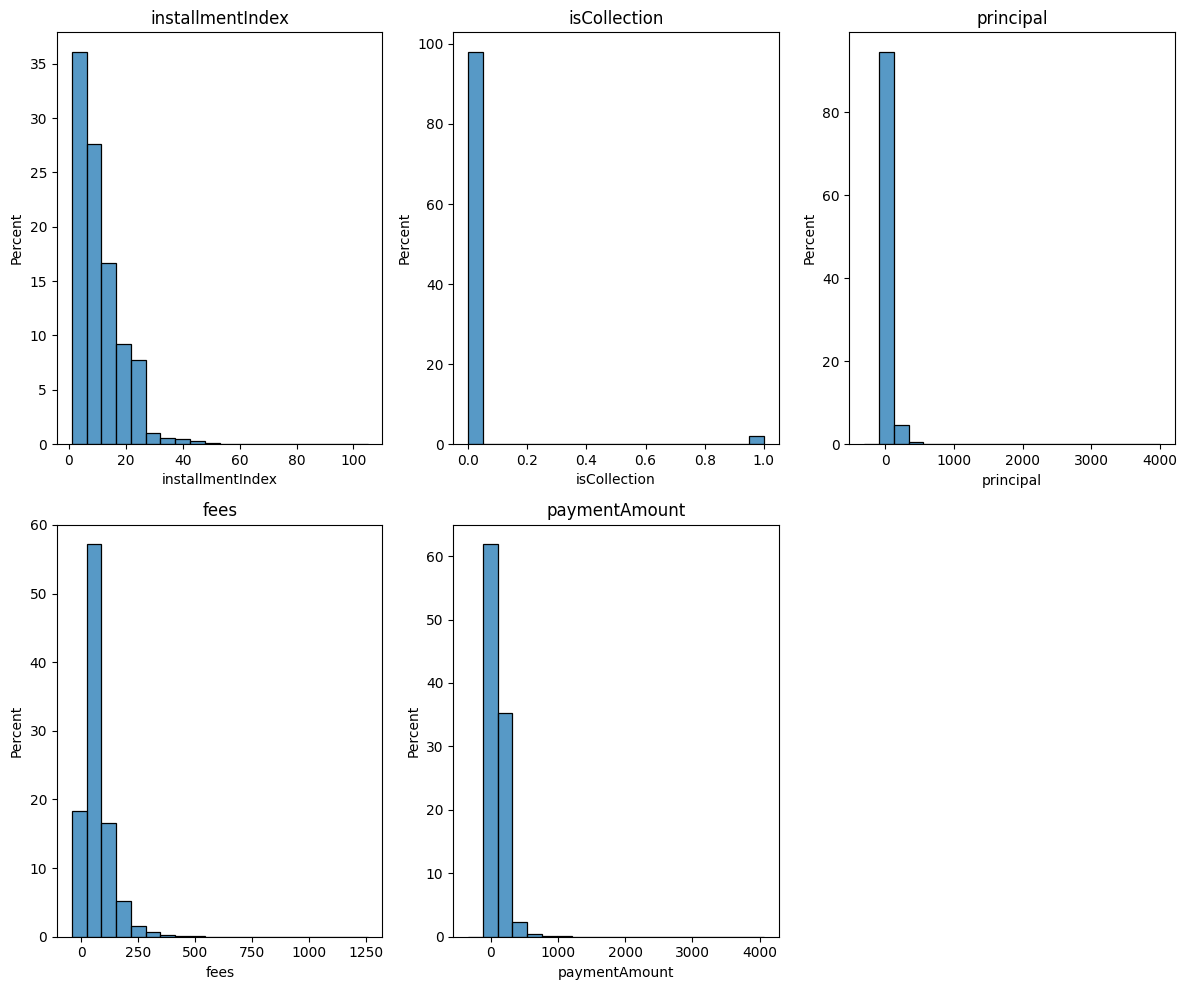

In [33]:
plot_numeric_columns(df_payment)

In [34]:
df_payment.describe(include="object")

loanId paymentStatus paymentReturnCode
count          689364        689364             31533
unique          39952             8                31
top     LL-I-12230332     Cancelled               R01
freq              105        270334             22866

In [35]:
plot_categorical(df_payment,["paymentStatus","paymentReturnCode"])

### TOP Rejection Causes
- 75% Insufficient Funds
-  8% Account Closed
-  7% Payment Stopped
-  3% Account Frozen

In [36]:
# Rejection Cause Distribution
tbl_return_code = pd.DataFrame(df_payment["paymentReturnCode"].value_counts(normalize=True)).reset_index()
tbl_return_code["ReturnCause"] = tbl_return_code["paymentReturnCode"].replace(ACH_codes)
tbl_return_code.head(5)

paymentReturnCode  proportion  \
0               R01    0.725145   
1               R02    0.087559   
2               R08    0.071639   
3               R16    0.034408   
4               R10    0.019662   

                                         ReturnCause  
0                                 Insufficient Funds  
1                                     Account Closed  
2            Payment Stopped or Stop Payment on Item  
3                                     Account Frozen  
4  Customer Advises Not Authorized, Item Is Ineli...

### isCollection Analysis
- 2.0% from all payments corresponds to a collection plan
- It seems that is an alternative plan created as a strategy to help customers pay their loan. 
- Will keep the information for the model

In [37]:
print(f"isCollection rate: {df_payment['isCollection'].mean():.2%}")

isCollection rate: 2.02%


In [38]:
df_payment[df_payment["isCollection"] == True].sample(6)

loanId  installmentIndex  isCollection paymentDate  principal  \
412604  LL-I-12408048                12          True  2017-03-24       0.00   
95661   LL-I-03880753                 3          True  2016-01-29      57.95   
97312   LL-I-03980211                 1          True  2015-12-24      84.55   
274022  LL-I-09628071                 2          True  2016-12-30      40.89   
350375  LL-I-11892639                 1          True  2017-01-13      25.00   
99441   LL-I-04092168                11          True  2016-03-10      38.21   

         fees  paymentAmount paymentStatus paymentReturnCode  
412604  57.12          57.12     Cancelled               NaN  
95661    0.00          57.95     Cancelled               NaN  
97312    0.00          84.55      Rejected               NaN  
274022   0.00          40.89     Cancelled               NaN  
350375   0.00          25.00      Rejected               NaN  
99441    0.00          38.21     Cancelled               NaN

Case 1

In [39]:
df_payment[df_payment["loanId"]=='LL-I-16664783']

loanId  installmentIndex  isCollection paymentDate  principal  \
597788  LL-I-16664783                 1         False  2017-02-17       0.00   
597789  LL-I-16664783                 2         False  2017-02-24       8.90   
597790  LL-I-16664783                 3         False  2017-03-03       9.74   
597791  LL-I-16664783                 4         False  2017-03-10      10.65   
597792  LL-I-16664783                 5         False  2017-03-17      11.65   
597793  LL-I-16664783                 6         False  2017-03-24      12.75   
597794  LL-I-16664783                 7         False  2017-03-31      13.95   
597795  LL-I-16664783                 8         False  2017-04-07      15.26   
597796  LL-I-16664783                 9         False  2017-04-14      16.69   
597797  LL-I-16664783                10         False  2017-04-21      18.26   
597798  LL-I-16664783                11         False  2017-04-28      19.98   
597799  LL-I-16664783                12         False  2017-05-05      21.85   
597800  LL-I-16664783                13         False  2017-05-12      23.91   
597801  LL-I-16664783                14         False  2017-05-19      26.15   
597802  LL-I-16664783                15         False  2017-05-26      28.61   
597803  LL-I-16664783                16         False  2017-06-02      31.30   
597804  LL-I-16664783                17         False  2017-06-09      34.24   
597805  LL-I-16664783                18         False  2017-06-16      37.46   
597806  LL-I-16664783                19         False  2017-06-23      40.98   
597807  LL-I-16664783                20         False  2017-06-30      44.83   
597808  LL-I-16664783                21         False  2017-07-07      49.04   
597809  LL-I-16664783                22         False  2017-07-14      53.65   
597810  LL-I-16664783                23         False  2017-07-21      58.69   
597811  LL-I-16664783                24         False  2017-07-28      64.21   
597812  LL-I-16664783                25         False  2017-08-04      70.24   
597813  LL-I-16664783                26         False  2017-08-11      77.01   
597814  LL-I-16664783                 1          True  2017-03-10     100.00   
597815  LL-I-16664783                 2          True  2017-03-17     136.39   
597816  LL-I-16664783                 3          True  2017-03-24     136.39   
597817  LL-I-16664783                 4          True  2017-03-31     136.39   
597818  LL-I-16664783                 5          True  2017-04-07     136.39   
597819  LL-I-16664783                 6          True  2017-04-14      54.44   
597820  LL-I-16664783                 7          True  2017-04-21       0.00   

          fees  paymentAmount paymentStatus paymentReturnCode  
597788  118.14         118.14      Rejected               R01  
597789   75.18          84.08      Rejected               R01  
597790   74.34          84.08     Cancelled               NaN  
597791   73.43          84.08     Cancelled               NaN  
597792   72.43          84.08     Cancelled               NaN  
597793   71.33          84.08     Cancelled               NaN  
597794   70.13          84.08     Cancelled               NaN  
597795   68.82          84.08     Cancelled               NaN  
597796   67.39          84.08     Cancelled               NaN  
597797   65.82          84.08     Cancelled               NaN  
597798   64.10          84.08     Cancelled               NaN  
597799   62.23          84.08     Cancelled               NaN  
597800   60.17          84.08     Cancelled               NaN  
597801   57.93          84.08     Cancelled               NaN  
597802   55.47          84.08     Cancelled               NaN  
597803   52.78          84.08     Cancelled               NaN  
597804   49.84          84.08     Cancelled               NaN  
597805   46.62          84.08     Cancelled               NaN  
597806   43.10          84.08     Cancelled               NaN  
597807   39.25

Case 2

In [40]:
df_payment[df_payment["loanId"]=='LL-I-07620614']

loanId  installmentIndex  isCollection paymentDate  principal  \
203646  LL-I-07620614                 1         False  2016-03-25       9.06   
203647  LL-I-07620614                 2         False  2016-04-08      42.14   
203648  LL-I-07620614                 3         False  2016-04-22      47.38   
203649  LL-I-07620614                 4         False  2016-05-06      53.26   
203650  LL-I-07620614                 5         False  2016-05-20      59.88   
203651  LL-I-07620614                 6         False  2016-06-03      67.32   
203652  LL-I-07620614                 7         False  2016-06-17      75.70   
203653  LL-I-07620614                 8         False  2016-07-01      85.11   
203654  LL-I-07620614                 9         False  2016-07-15      95.68   
203655  LL-I-07620614                10         False  2016-07-29     107.57   
203656  LL-I-07620614                11         False  2016-08-12     120.93   
203657  LL-I-07620614                12         False  2016-08-26     135.97   
203658  LL-I-07620614                 1          True  2016-11-03     364.47   
203659  LL-I-07620614                 2          True  2016-11-03       0.00   

          fees  paymentAmount paymentStatus paymentReturnCode  
203646  143.80         152.86       Checked               NaN  
203647  110.72         152.86       Checked               NaN  
203648  105.48         152.86       Checked               NaN  
203649   99.60         152.86       Checked               NaN  
203650   92.98         152.86       Checked               NaN  
203651   85.54         152.86       Checked               NaN  
203652   77.17         152.87       Checked               NaN  
203653   67.76         152.87       Checked               NaN  
203654   57.18         152.86       Checked               NaN  
203655   45.29         152.86      Rejected               R02  
203656   31.93         152.86     Cancelled               NaN  
203657   16.90         152.87     Cancelled               NaN  
203658   45.29         409.76       Checked               NaN  
203659    0.00           0.00       Checked               NaN

Case 3

In [41]:
df_payment[df_payment["loanId"]=='LL-I-12828482']

loanId  installmentIndex  isCollection paymentDate  principal  \
446580  LL-I-12828482                 1         False  2016-12-30      18.27   
446581  LL-I-12828482                 2         False  2017-01-13      40.46   
446582  LL-I-12828482                 3         False  2017-01-31       0.00   
446583  LL-I-12828482                 4         False  2017-02-15      29.09   
446584  LL-I-12828482                 5         False  2017-02-28      69.04   
446585  LL-I-12828482                 6         False  2017-03-15      55.10   
446586  LL-I-12828482                 7         False  2017-03-31      55.78   
446587  LL-I-12828482                 8         False  2017-04-14      97.43   
446588  LL-I-12828482                 9         False  2017-04-28     121.53   
446589  LL-I-12828482                10         False  2017-05-15     124.39   
446590  LL-I-12828482                11         False  2017-05-31     168.63   
446591  LL-I-12828482                12         False  2017-06-15     220.28   
446592  LL-I-12828482                 1          True  2017-02-20     600.00   
446593  LL-I-12828482                 2          True  2017-02-21     600.00   
446594  LL-I-12828482                 3          True  2017-03-24     341.27   

          fees  paymentAmount paymentStatus paymentReturnCode  
446580  265.07         283.34       Checked               NaN  
446581  242.88         283.34       Checked               NaN  
446582  299.40         299.40      Rejected               R01  
446583  249.50         278.59      Rejected               R01  
446584  209.55         278.59     Cancelled               NaN  
446585  223.49         278.59     Cancelled               NaN  
446586  222.81         278.59     Cancelled               NaN  
446587  181.16         278.59     Cancelled               NaN  
446588  157.06         278.59     Cancelled               NaN  
446589  154.20         278.59     Cancelled               NaN  
446590  109.96         278.59     Cancelled               NaN  
446591   58.39         278.67     Cancelled               NaN  
446592    0.00         600.00       Checked               NaN  
446593    0.00         600.00     Cancelled               NaN  
446594    0.00         341.27     Scheduled               NaN

### Comparable Loans
There are 2 ways to have comparable loans for a ML model
1. Consider only Closed Loans
2. Consider all loans with enough performance to a specific time window (As there are many payment frequency and they do not have explicit Tenor, this a little more complex)

So, will go for option 1
- Loans with NO Scheduled Payments must be Closed Loans.
- Let's keep only Closed Loans to have comparable loans

TradeOffs?
- Less volumen but more accuracy than using an early metric

In [42]:
# Identify Loans with Scheduled payment
df_payment["isScheduledPayment"] = np.where(df_payment["paymentStatus"]=="Scheduled", 1, 0)
df_scheduled_payment = df_payment.groupby("loanId").agg({"isScheduledPayment":"max"})

lst_scheduled_loans = df_scheduled_payment[df_scheduled_payment['isScheduledPayment'] == 1].index.tolist()

print(df_scheduled_payment.value_counts())
print(df_scheduled_payment.value_counts(normalize=True).round(3))


isScheduledPayment
0                     24872
1                     15080
Name: count, dtype: int64
isScheduledPayment
0                     0.623
1                     0.377
Name: proportion, dtype: float64


In [43]:
# Identify ClosedLoans 
df_payment["isClosedLoan"] = np.where(df_payment["loanId"].isin(lst_scheduled_loans),0,1)
df_payment["paymentAmountPaid"] = np.where(df_payment["paymentStatus"]=="Checked",df_payment["paymentAmount"],0)
df_payment["principalPaid"] = np.where(df_payment["paymentStatus"]=="Checked",df_payment["principal"],0)
df_payment["feesPaid"] = np.where(df_payment["paymentStatus"]=="Checked",df_payment["fees"],0)

df_payment

loanId  installmentIndex  isCollection paymentDate  principal  \
0       LL-I-00000021                 1         False  2014-12-19      22.33   
1       LL-I-00000021                 2         False  2015-01-02      26.44   
2       LL-I-00000021                 3         False  2015-01-16      31.30   
3       LL-I-00000021                 4         False  2015-01-30      37.07   
4       LL-I-00000021                 5         False  2015-02-13      43.89   
...               ...               ...           ...         ...        ...   
689359  LL-I-18629478                 8         False  2017-07-14      45.62   
689360  LL-I-18629478                 9         False  2017-07-31      45.67   
689361  LL-I-18629478                10         False  2017-08-15      51.12   
689362  LL-I-18629478                11         False  2017-08-31      54.35   
689363  LL-I-18629478                12         False  2017-09-15      58.83   

          fees  paymentAmount paymentStatus paymentReturnCode  \
0       147.28         169.61       Checked               NaN   
1       143.17         169.61       Checked               NaN   
2       138.31         169.61       Checked               NaN   
3       132.54         169.61       Checked               NaN   
4       125.72         169.61       Checked               NaN   
...        ...            ...           ...               ...   
689359   17.67          63.29     Scheduled               NaN   
689360   17.62          63.29     Scheduled               NaN   
689361   12.17          63.29     Scheduled               NaN   
689362    8.94          63.29     Scheduled               NaN   
689363    4.36          63.19     Scheduled               NaN   

        isScheduledPayment  isClosedLoan  paymentAmountPaid  principalPaid  \
0                        0             1             169.61          22.33   
1                        0             1             169.61          26.44   
2                        0             1             169.61          31.30   
3                        0             1             169.61          37.07   
4                        0             1             169.61          43.89   
...                    ...           ...                ...            ...   
689359                   1             0               0.00           0.00   
689360                   1             0               0.00           0.00   
689361                   1             0               0.00           0.00   
689362                   1             0               0.00           0.00   
689363                   1             0               0.00           0.00   

        feesPaid  
0         147.28  
1         143.17  
2         138.31  
3         132.54  
4         125.72  
...          ...  
689359      0.00  
689360      0.00  
689361      0.00  
689362      0.00  
689363      0.00  

[689364 rows x 14 columns]

In [44]:
df_payment_summ = df_payment[df_payment["isCollection"]==False].groupby(["loanId","isClosedLoan"]).agg({
    "paymentAmountPaid" : "sum",
    "principalPaid" : "sum",
    "feesPaid" : "sum",
    }
).reset_index()
df_payment_summ

loanId  isClosedLoan  paymentAmountPaid  principalPaid  feesPaid
0      LL-I-00000021             1            1865.60         697.83   1167.77
1      LL-I-00000231             0             258.64          27.20    231.44
2      LL-I-00000238             0            1162.60         259.46    903.14
3      LL-I-00000308             0              61.59           3.61     57.98
4      LL-I-00000355             0               0.00           0.00      0.00
...              ...           ...                ...            ...       ...
39947  LP-I-00000127             1             872.52         810.00     62.52
39948  LP-I-00000134             1             869.70         869.00      0.70
39949  LP-I-00000139             1             910.25         845.00     65.25
39950  LP-I-00000142             1               0.00           0.00      0.00
39951  LP-I-00000145             1             807.49         749.00     58.49

[39952 rows x 5 columns]

## 3 Join Loans + Payment

### Join Tables

In [45]:
df_conso = pd.merge(
    left = df_valid_loans,
    right = df_payment_summ,
    how="left",
    on="loanId"
)

In [46]:
df_conso

loanId                          anon_ssn payFrequency    apr  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
1      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
2      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
3      LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8            W  590.0   
4      LL-I-15095423  30c4d360865b5b3591e81dcf681f0a74            S  590.0   
...              ...                               ...          ...    ...   
30795  LL-I-17508871  f0b666fdd1b46c58297b3828b61047ad            M  180.2   
30796  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0   
30797  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0   
30798  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0   
30799  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.0   

      applicationDate  originated originatedDate  nPaidOff  approved  \
0          2016-01-19        True     2016-01-20       0.0      True   
1          2017-03-01        True     2017-03-01       0.0      True   
2          2016-08-27        True     2016-08-29       0.0      True   
3          2015-05-26        True     2015-05-26       0.0      True   
4          2017-01-13        True     2017-01-13       0.0      True   
...               ...         ...            ...       ...       ...   
30795      2017-02-21        True     2017-02-21       0.0      True   
30796      2017-01-14        True     2017-01-14       0.0      True   
30797      2016-06-22        True     2016-06-22       0.0      True   
30798      2016-12-30        True     2016-12-30       0.0      True   
30799      2016-12-16        True     2016-12-16       0.0      True   

       isFunded     loanStatus  loanAmount  originallyScheduledPaymentAmount  \
0             1  Paid Off Loan      3000.0                           6395.19   
1             1       New Loan       400.0                           1364.87   
2             1  Paid Off Loan       800.0                           2432.08   
3             1  Paid Off Loan       300.0                            896.87   
4             1       New Loan       600.0                           1802.83   
...         ...            ...         ...                               ...   
30795         1  Returned Item       500.0                            794.60   
30796         1  Paid Off Loan       375.0                           1042.40   
30797         1  Paid Off Loan       400.0                            664.12   
30798         1       New Loan       600.0                           1868.88   
30799         1  Paid Off Loan       300.0                           1034.38   

      state     leadType  leadCost  fpStatus            clarityFraudId  hasCF  \
0        CA    prescreen         0   Checked  569eb3a3e4b096699f685d64      1   
1        NJ         lead        40   Checked  58b6eef8e4b0b6fca82fd426      1   
2        CA  bvMandatory        10   Checked  578f9346e4b0810ad5e7b72e      1   
3        MO  bvMandatory         6  Rejected                       NaN      0   
4        MI         lead        25   Checked  5878b8ade4b08f24825292a4      1   
...     ...          ...       ...       ...                       ...    ...   
30795    CO         lead        25  Rejected  58aca342e4b0bf804c0e82db      1   
30796    AL         lead        25   Checked  587a7f49e4b08f2485d48358      1   
30797    WI         lead        40   Checked  5769e592e4b0ab6c50364d45      1   
30798    IN         lead        25   Checked  58668211e4b08f246e282356      1   
30799    CT         lead         6   Checked  5840ad86e4b0bb9d6980127f      1   

       isClosedLoan  paymentAmountPaid  principalPaid  feesPaid  
0               1.0            6287.08        3000.00   3287.08  
1               0.0               0.00           0.00      0.00  
2               1.0            2432.08         800.00   1632.08  
3             

### Null Values

In [47]:
null_detection(df_conso)

Null count per column:
clarityFraudId       2361
isClosedLoan           84
paymentAmountPaid      84
principalPaid          84
feesPaid               84
fpStatus                8
dtype: int64

Percentage of nulls per column:
clarityFraudId       7.67
isClosedLoan         0.27
paymentAmountPaid    0.27
principalPaid        0.27
feesPaid             0.27
fpStatus             0.03
dtype: float64


In [48]:
# Fill Real 0 columns
df_conso["isClosedLoan"] = df_conso["isClosedLoan"].fillna(0)
df_conso["paymentAmountPaid"] = df_conso["paymentAmountPaid"].fillna(0)
df_conso["principalPaid"] = df_conso["principalPaid"].fillna(0)
df_conso["feesPaid"] = df_conso["feesPaid"].fillna(0)

In [49]:
null_detection(df_conso)

Null count per column:
clarityFraudId    2361
fpStatus             8
dtype: int64

Percentage of nulls per column:
clarityFraudId    7.67
fpStatus          0.03
dtype: float64


### Filter Closed Loans

In [50]:
df_closed_loans = df_conso[df_conso["isClosedLoan"]==1].copy()

In [51]:
# Volume Pipeline
VolPipeline["Closed Loans"] = len(df_closed_loans)

VolPipeline

{'Applications': 577682,
 'Funded Loans': 38982,
 'First Time Clients': 30834,
 'Clients w/ Only 1 Active Loan': 30800,
 'Closed Loans': 18600}

## Target Definition

- Compute Margin Variables

In [52]:
df_closed_loans["GrossMargin"] = df_closed_loans["paymentAmountPaid"] - df_closed_loans["loanAmount"]
df_closed_loans["NetMargin"] = df_closed_loans["GrossMargin"] - df_closed_loans["leadCost"]
df_closed_loans["NetMargin_pct"] = df_closed_loans["NetMargin"] / df_closed_loans["loanAmount"]

Compute 2 possible Target Variables

- Risk
    - 1 if NetMargin < 0
    - 0 if NetMargin >= 0

- HighRisk
    - 1 if NetMargin_pct < -50%
    - 0 if NetMargin_pct >= -50%

Targets:
- Risk (50% Population)
- HighRisk (37% Population)

In [53]:
df_closed_loans["Risk"] = np.where(df_closed_loans["NetMargin"]<0, 1, 0)
df_closed_loans["HighRisk"] = np.where(df_closed_loans["NetMargin_pct"]<-.5, 1, 0)

df_closed_loans.sort_values(by="NetMargin_pct")

loanId                          anon_ssn payFrequency     apr  \
1781   LL-I-01300770  6239dc82c6dae0ba778c8dfdd7d9a8f8            B  525.00   
30384  LL-I-08635811  ac0b68312498f2cdc5b0c0bff358a9e4            S  681.00   
571    LL-I-04859224  fc7a2f176f9fb0b44ca5ccd175e027cf            W  590.00   
25297  LL-I-04190113  dbaba48e65fc3317191976d3ab20ec6d            B  590.00   
10539  LL-I-01638733  a261abda3ff406d36c9f001b89f764e8            B  390.00   
...              ...                               ...          ...     ...   
30687  LL-I-00364555  36b2ff04b54cbef47d89c99428e61281            M  590.00   
8380   LL-I-00199007  7f155e3cc1dda4299a073936e460e407            M  570.32   
24132  LL-I-00303345  d44c9993c61b562242a675b4de076769            M  590.00   
27038  LL-I-00263396  094c024aad462017881bb363e743a356            M  590.00   
15786  LL-I-00376483  a76908faf84faf07ef097ddf750db4cc            M  650.00   

      applicationDate  originated originatedDate  nPaidOff  approved  \
1781       2015-05-25        True     2015-05-26       0.0      True   
30384      2016-04-12        True     2016-04-12       0.0      True   
571        2015-11-21        True     2015-11-23       0.0      True   
25297      2015-10-30        True     2015-11-03       0.0      True   
10539      2015-07-04        True     2015-07-05       0.0      True   
...               ...         ...            ...       ...       ...   
30687      2015-03-12        True     2015-03-12       0.0      True   
8380       2015-01-29        True     2015-01-29       0.0      True   
24132      2015-03-02        True     2015-03-02       0.0      True   
27038      2015-02-21        True     2015-03-20       0.0      True   
15786      2015-03-14        True     2015-03-16       0.0      True   

       isFunded            loanStatus  loanAmount  \
1781          1  Charged Off Paid Off       300.0   
30384         1  Charged Off Paid Off       300.0   
571           1   External Collection       750.0   
25297         1   External Collection       900.0   
10539         1   Settlement Paid Off       500.0   
...         ...                   ...         ...   
30687         1         Paid Off Loan       300.0   
8380          1         Paid Off Loan       400.0   
24132         1         Paid Off Loan       300.0   
27038         1         Paid Off Loan       300.0   
15786         1         Paid Off Loan       300.0   

       originallyScheduledPaymentAmount state     leadType  leadCost  \
1781                             834.64    OH         lead       170   
30384                           1079.65    OH         lead        75   
571                             2242.23    OH         lead       170   
25297                           2495.24    OH         lead       200   
10539                           1074.16    TX         lead       100   
...                                 ...   ...          ...       ...   
30687                           1735.14    TX  bvMandatory         3   
8380                            2120.58    OH  bvMandatory         3   
24132                           1710.82    TX  bvMandatory         3   
27038                           1774.05    MO  bvMandatory         3   
15786                           1899.34    OH  bvMandatory         3   

        fpStatus            clarityFraudId  hasCF  isClosedLoan  \
1781   Cancelled  54fa5438e4b020645d1a2872      1           1.0   
30384   Rejected  570d0ec0e4b06ef4830047fc      1           1.0   
571     Rejected  55d47169e4b0ac3740e810e2      1           1.0   
25297   Rejected  5554f207e4b03ea9cdf938ee      1           1.0   
10539  Cancelled  557193d0e4b0a03135ab4b72      1           1.0   
...          ...                       ...    ...           ...   
30687    Checked                       NaN      0           1.0   
8380     Checked                       NaN      0           1.0   
24132    Checked                       NaN      0           1.0   
27038    Checked            

In [54]:
df_closed_loans[["GrossMargin","NetMargin","NetMargin_pct","Risk","HighRisk"]].describe()

GrossMargin     NetMargin  NetMargin_pct          Risk      HighRisk
count  18600.000000  18600.000000   18600.000000  18600.000000  18600.000000
mean      58.821674     45.355545       0.141900      0.508602      0.379301
std      678.275292    675.946891       1.002070      0.499939      0.485226
min    -3500.000000  -3525.000000      -1.566667      0.000000      0.000000
25%     -350.000000   -353.000000      -0.772741      0.000000      0.000000
50%        0.000000    -11.815000      -0.023233      1.000000      0.000000
75%      437.305000    422.192500       0.983189      1.000000      1.000000
max     5477.720000   5477.720000       5.321167      1.000000      1.000000

## 4 Prior DF

### Load Data

In [55]:
#df_prior = pd.read_csv(r'..\data\raw\clarity_underwriting_variables.csv', low_memory=False)
df_prior = bucket.read_csv(file='clarity_underwriting_variables.csv')
print(df_prior.shape)
df_prior.head(5)

(49752, 54)


.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
0                                                8.0                     
1                                                5.0                     
2                                                9.0                     
3                                                3.0                     
4                                                5.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
0                                                2.0                          
1                                                2.0                          
2                                                4.0                          
3                                                2.0                          
4                                                5.0                          

   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
0                                                2.0                    
1                                                2.0                    
2                                                2.0                    
3                                                2.0                    
4                                                2.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
0                                                2.0                  
1                                                2.0                  
2                                                3.0                  
3                                                2.0                  
4                                                2.0                  

   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
0                                                8.0                     
1                                               11.0                     
2                                               10.0                     
3                                                9.0                     
4                                                6.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago  \
0                                                2.0                    
1                                                2.0                    
2                                                8.0                    
3                                                2.0                    
4                                                5.0                    

   .underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago  \
0                                                2.0                     
1                                                2.0                     
2                                                2.0                     
3                                                2.0                     
4                                                2.0                     

   .underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago  \
0                                                5.0                      
1                                                4.0                      
2                                                9.0                      
3                                                2.0                      
4                                                5.0                      

   .underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago  \
0                                               10.0                             
1                                               21.0                             
2                                               25.0                             
3                                                9.0                             
4                          

In [56]:
new_columns = df_prior.columns.str.split('.').str[-1:].str.join('_').to_list()
df_prior.columns = new_columns
df_prior.head(5)

thirtydaysago  twentyfourhoursago  oneminuteago  onehourago  ninetydaysago  \
0            8.0                 2.0           2.0         2.0            8.0   
1            5.0                 2.0           2.0         2.0           11.0   
2            9.0                 4.0           2.0         3.0           10.0   
3            3.0                 2.0           2.0         2.0            9.0   
4            5.0                 5.0           2.0         2.0            6.0   

   sevendaysago  tenminutesago  fifteendaysago  threesixtyfivedaysago  \
0           2.0            2.0             5.0                   10.0   
1           2.0            2.0             4.0                   21.0   
2           8.0            2.0             9.0                   25.0   
3           2.0            2.0             2.0                    9.0   
4           5.0            2.0             5.0                    6.0   

  inquiryonfilecurrentaddressconflict  totalnumberoffraudindicators  \
0                               False                           2.0   
1                                True                           3.0   
2                               False                           3.0   
3                               False                           1.0   
4                               False                           1.0   

  telephonenumberinconsistentwithaddress inquiryageyoungerthanssnissuedate  \
0                                   True                             False   
1                                   True                             False   
2                                   True                             False   
3                                   True                             False   
4                                   True                             False   

  onfileaddresscautious inquiryaddressnonresidential onfileaddresshighrisk  \
0                 False                         True                 False   
1                 False                        False                 False   
2                 False                        False                 False   
3                 False                        False                 False   
4                 False                        False                 False   

  ssnreportedmorefrequentlyforanother  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   

  currentaddressreportedbytradeopenlt90days inputssninvalid  \
0                                     False           False   
1                                     False           False   
2                                     False           False   
3                                     False           False   
4                                     False           False   

  inputssnissuedatecannotbeverified inquiryaddresscautious  \
0                             False                  False   
1                             False                  False   
2                             False                  False   
3                             False                  False   
4                             False                  False   

  morethan3inquiriesinthelast30days onfileaddressnonresidential  \
0                             False                       False   
1                             False                       False   
2                             False                       False   
3                             False                       False   
4                             False                       False   

  creditestablishedpriortossnissuedate driverlicenseformatinvalid  ...  \
0                                False                        NaN  ...   
1                                False                        NaN  ...   
2                                False                        NaN  ...   
3             

### Drop Irrelevant Columns

In [57]:
#Drop Columns with 1 unique value
columns_to_drop = df_prior.columns[df_prior.nunique() == 1].to_list()
df_prior.drop(columns=columns_to_drop, inplace=True)

print("Dropped Columns with 1 unique value:")
columns_to_drop

Dropped Columns with 1 unique value:


['inputssninvalid',
 'inputssnrecordedasdeceased',
 'bestonfilessnissuedatecannotbeverified',
 'bestonfilessnrecordedasdeceased',
 'nameaddressreasoncodedescription',
 'nameaddressreasoncode']

### Null Values

In [58]:
null_detection(df_prior)

Null count per column:
phonetype                                    48237
ssnnamereasoncode                            47083
ssnnamereasoncodedescription                 47083
ssndobreasoncode                             40723
driverlicenseinconsistentwithonfile          39697
workphonepreviouslylistedashomephone         28336
workphonepreviouslylistedascellphone         28336
driverlicenseformatinvalid                    5049
phonematchtypedescription                      953
phonematchtype                                 953
telephonenumberinconsistentwithstate           681
clearfraudscore                                137
inquiryageyoungerthanssnissuedate               40
creditestablishedpriortossnissuedate            40
phonematchresult                                40
inquiryonfilecurrentaddressconflict             40
telephonenumberinconsistentwithaddress          40
onfileaddresscautious                           40
currentaddressreportedbynewtradeonly            40
highprob

### Keep customers with clearfraudscore
- Because Filtering customers with clearfraudscore, drops many variables with few nulls
- This simplifies Missing Treatment 

In [59]:
df_prior.dropna(subset="clearfraudscore", inplace=True)

In [60]:
null_detection(df_prior)

Null count per column:
phonetype                               48104
ssnnamereasoncodedescription            46950
ssnnamereasoncode                       46950
ssndobreasoncode                        40604
driverlicenseinconsistentwithonfile     39588
workphonepreviouslylistedascellphone    28265
workphonepreviouslylistedashomephone    28265
driverlicenseformatinvalid               5013
phonematchtype                            913
phonematchtypedescription                 913
telephonenumberinconsistentwithstate      664
dtype: int64

Percentage of nulls per column:
phonetype                               96.95
ssnnamereasoncodedescription            94.63
ssnnamereasoncode                       94.63
ssndobreasoncode                        81.84
driverlicenseinconsistentwithonfile     79.79
workphonepreviouslylistedascellphone    56.97
workphonepreviouslylistedashomephone    56.97
driverlicenseformatinvalid              10.10
phonematchtype                           1.84
phonematcht

### Missing Treatment

- Drop Columns with Very High Null Rate

In [61]:
# Very High nulls
drop_columns =[
    "phonetype",
    "ssnnamereasoncode",
    "ssnnamereasoncodedescription",
    "ssndobreasoncode",
]
df_prior = df_prior.drop(columns=drop_columns)

In [62]:
# Check Nulls
null_detection(df_prior)

Null count per column:
driverlicenseinconsistentwithonfile     39588
workphonepreviouslylistedascellphone    28265
workphonepreviouslylistedashomephone    28265
driverlicenseformatinvalid               5013
phonematchtype                            913
phonematchtypedescription                 913
telephonenumberinconsistentwithstate      664
dtype: int64

Percentage of nulls per column:
driverlicenseinconsistentwithonfile     79.79
workphonepreviouslylistedascellphone    56.97
workphonepreviouslylistedashomephone    56.97
driverlicenseformatinvalid              10.10
phonematchtype                           1.84
phonematchtypedescription                1.84
telephonenumberinconsistentwithstate     1.34
dtype: float64


- Fill Risk Flags with FALSE

In [63]:
# Nulls Flags -> Filled with FALSE
fill_w_False =[
    "driverlicenseinconsistentwithonfile",
    "workphonepreviouslylistedashomephone",
    "workphonepreviouslylistedascellphone",
    "driverlicenseformatinvalid",
    "telephonenumberinconsistentwithstate",
]
df_prior[fill_w_False] = df_prior[fill_w_False].fillna(False)

C:\Users\luigi\AppData\Local\Temp\ipykernel_25568\431329701.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prior[fill_w_False] = df_prior[fill_w_False].fillna(False)


- Fill categorical with Low Null rate with "MISS"

In [64]:
# Fill Categorical with "MISS"
df_prior["phonematchtype"] = df_prior["phonematchtype"].fillna("MISS")
df_prior["phonematchtypedescription"] = df_prior["phonematchtypedescription"].fillna("MISS")


In [65]:
# Check Nulls
null_detection(df_prior)

Null count per column:
Series([], dtype: int64)

Percentage of nulls per column:
Series([], dtype: float64)


## 5 Join Loans + Pay + Prior

### Join ALL 3 DF

In [66]:
full_data_df = pd.merge(
    left = df_closed_loans,
    right = df_prior,
    how="inner",
    left_on =  "clarityFraudId",
    right_on = "underwritingid",
)

In [67]:
full_data_df

loanId                          anon_ssn payFrequency     apr  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.00   
1      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.00   
2      LL-I-04577739  edac6e371cda7512214ba74698247a19            B  601.00   
3      LL-I-07240030  7a2dabf0d9fe553dd4136b17e3dca40b            B  590.00   
4      LL-I-08315344  395ad51b7795fe0b93a6a2aa3e44983a            W  449.99   
...              ...                               ...          ...     ...   
17501  LL-I-05352479  c54fe4772636b36b0727b735b85d0254            W  590.00   
17502  LL-I-15390953  c81e355845a451b77c29b6515efa2578            B  645.00   
17503  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.00   
17504  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.00   
17505  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.00   

      applicationDate  originated originatedDate  nPaidOff  approved  \
0          2016-01-19        True     2016-01-20       0.0      True   
1          2016-08-27        True     2016-08-29       0.0      True   
2          2015-11-12        True     2015-11-12       0.0      True   
3          2016-02-14        True     2016-02-17       0.0      True   
4          2016-04-01        True     2016-04-01       0.0      True   
...               ...         ...            ...       ...       ...   
17501      2015-12-05        True     2015-12-06       0.0      True   
17502      2017-01-16        True     2017-01-16       0.0      True   
17503      2017-01-14        True     2017-01-14       0.0      True   
17504      2016-06-22        True     2016-06-22       0.0      True   
17505      2016-12-16        True     2016-12-16       0.0      True   

       isFunded           loanStatus  loanAmount  \
0             1        Paid Off Loan      3000.0   
1             1        Paid Off Loan       800.0   
2             1        Paid Off Loan       600.0   
3             1        Paid Off Loan       500.0   
4             1  External Collection       600.0   
...         ...                  ...         ...   
17501         1        Paid Off Loan       600.0   
17502         1        Paid Off Loan      1500.0   
17503         1        Paid Off Loan       375.0   
17504         1        Paid Off Loan       400.0   
17505         1        Paid Off Loan       300.0   

       originallyScheduledPaymentAmount state     leadType  leadCost  \
0                               6395.19    CA    prescreen         0   
1                               2432.08    CA  bvMandatory        10   
2                               1616.20    SC         lead        10   
3                               1368.75    OH  bvMandatory         3   
4                               1562.97    NV  bvMandatory         3   
...                                 ...   ...          ...       ...   
17501                           1806.65    IN  bvMandatory         3   
17502                           5111.56    ND         lead        25   
17503                           1042.40    AL         lead        25   
17504                            664.12    WI         lead        40   
17505                           1034.38    CT         lead         6   

       fpStatus            clarityFraudId  hasCF  isClosedLoan  \
0       Checked  569eb3a3e4b096699f685d64      1           1.0   
1       Checked  578f9346e4b0810ad5e7b72e      1           1.0   
2       Checked  557716a4e4b0a648a068ade3      1           1.0   
3      Rejected  56c4a889e4b081940c382a71      1           1.0   
4       Checked  56fea406e4b0f1e5d1eb5c2b      1           1.0   
...         ...                       ...    ...           ...   
17501   Checked  56630dfee4b0100e8495f049      1           1.0   
17502   Checked  587c527ce4b08f2487e808ba      1           1.0   
17503   Checked  587a7f49e4b08f2485d48358      1           1.0   
17504   Checked  5769e592e4b0ab6c50364d45      1  

In [68]:
# Check Nulls
null_detection(full_data_df)

Null count per column:
Series([], dtype: int64)

Percentage of nulls per column:
Series([], dtype: float64)


### FINAL DF

In [69]:
VolPipeline["Final_DF"] = len(full_data_df)

VolPipeline

{'Applications': 577682,
 'Funded Loans': 38982,
 'First Time Clients': 30834,
 'Clients w/ Only 1 Active Loan': 30800,
 'Closed Loans': 18600,
 'Final_DF': 17506}

### Save Table

In [70]:
#full_data_df.to_csv(r'..\data\output\full_data_df.csv', index = False)

In [71]:
# DFs to upload
dfs_to_upload = [
    (full_data_df, 'output/full_data_df.csv'),
    ]

In [72]:
# upload dfs
bucket.upload_df_as_csv(dfs_to_upload, replace=True)

File 'output/full_data_df.csv' already exists in bucket. File replaced.
